# End-to-End Machine Learning Project

## To build a machine learning model, you need to go through several stages. Let’s break them down step by step — from data collection to the final prediction.

## -------------------------------------------------------------------------------------------------

### 1️⃣ Data Collection and Loading

In [216]:
import os
import tarfile
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from six.moves import urllib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [50]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    with tarfile.open(tgz_path) as housing_tgz:
        housing_tgz.extractall(path=housing_path)

fetch_housing_data()

In [158]:
housing = pd.read_csv("datasets/housing/housing.csv")
housing = housing.drop("ocean_proximity", axis=1)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


### 2️⃣ Train/Test Split

#### We need to split the data into training and test sets so the model can generalize to new data. 
#### 📌 Example of splitting (80% for training, 20% for testing):

In [162]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### 3️⃣ Exploratory Data Analysis (EDA)

#### Before training, it’s crucial to explore the data:

#### ✔️ Are there missing values?

#### ✔️ How are the variables distributed?

#### ✔️ Are there any outliers?

#### ✔️ What are the most important features?

In [166]:
housing.describe() 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


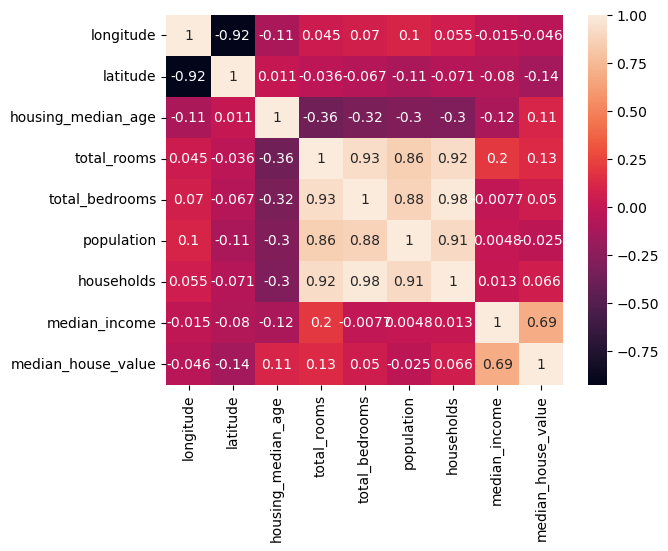

In [173]:
corr = housing.corr()
sns.heatmap(corr, annot=True)
plt.show()

### 4️⃣ Data Preprocessing

#### 1. Handling missing values

In [177]:
housing["total_bedrooms"].fillna(housing["total_bedrooms"].median(), inplace=True)

### 5️⃣ Model Selection and Training

#### 📌 Example with RandomForestRegressor:

In [181]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(train_set.drop("median_house_value", axis=1), train_set["median_house_value"])

RandomForestRegressor(random_state=42)

### 6️⃣ Model Evaluation (Cross-validation)

#### We check how well the model works on test data.

#### 📌 Regression metrics:

#### MSE (Mean Squared Error) — the average of squared errors

#### RMSE (Root Mean Squared Error) — the square root of MSE

#### MAE (Mean Absolute Error) — the average of absolute errors

In [192]:
predictions = forest_reg.predict(test_set.drop("median_house_value", axis=1))
mse = mean_squared_error(test_set["median_house_value"], predictions)
rmse = mse ** 0.5
print("RMSE:", rmse)

RMSE: 49840.09626051366


#### Cross-validation (cross_val_score)

In [195]:
scores = cross_val_score(forest_reg, train_set.drop("median_house_value", axis=1),
                         train_set["median_house_value"],
                         scoring="neg_mean_squared_error", cv=5)

rmse_scores = (-scores) ** 0.5
print("Average RMSE:", rmse_scores.mean())

Average RMSE: 50008.33091000542


### 7️⃣ Hyperparameter Tuning (GridSearchCV)

In [200]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': [5, 10, 20]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(train_set.drop("median_house_value", axis=1), train_set["median_house_value"])

print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_features': 5, 'n_estimators': 100}


### 8️⃣ Final Prediction (Predict)

In [202]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"]

final_predictions = final_model.predict(X_test)

In [210]:
final_predictions

array([ 49514.  ,  71100.  , 459757.44, ..., 492332.91,  70974.  ,
       182272.  ])

In [204]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                                    loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

print("Confidence interval for RMSE:", interval)

Confidence interval for RMSE: [46640.89418091 50871.12922438]


### 🛠 Final Process Summary

#### ✅ 1. Data Collection

#### ✅ 2. Train/Test Split

#### ✅ 3. Exploratory Data Analysis (EDA)

#### ✅ 4. Data Preprocessing

#### ✅ 5. Model Training

#### ✅ 6. Model Evaluation

#### ✅ 7. Hyperparameter Tuning

#### ✅ 8. Final Prediction